In [1]:
import Pkg
Pkg.activate("jupyter")
Pkg.instantiate()

Activating environment at `~/LeNet.jl/jupyter/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
using Images
using Knet

if Knet.gpu() >= 0
    ATYPE = KnetArray{Float32}
    to_nn = gpucopy
else
    ATYPE = Array{Float32}
    to_nn = identity
end
ATYPE

KnetArray{Float32,N} where N

In [3]:
using LeNet.MNIST

train_images, train_labels, _ = train_dataset(padding=2)
test_images, test_labels, _ = test_dataset(padding=2)

@show typeof(train_images)
@show size(train_images)
@show typeof(train_labels)
@show size(train_labels)

# prepare testing batches
train_data_chk = minibatch(train_images, train_labels, 5000; xtype=ATYPE);
test_data_chk = minibatch(test_images, test_labels, 5000; xtype=ATYPE);

typeof(train_images) = PaddedViews.PaddedView{Float16,3,Tuple{Base.OneTo{Int64},Base.OneTo{Int64},Base.OneTo{Int64}},OffsetArrays.OffsetArray{Float16,3,Array{Float16,3}}}
size(train_images) = (32, 32, 60000)
typeof(train_labels) = Array{Int64,1}
size(train_labels) = (60000,)


In [4]:
using LeNet, Printf

model = load_model(LeNet5, "LeNet5-model.jld2")

@printf "accuracy(train_data) = %f %%\n" (accuracy(x -> last(model(x)), train_data_chk)*100)
@printf "accuracy(test_data) = %f %%\n" (accuracy(x -> last(model(x)), test_data_chk)*100)

accuracy(train_data) = 98.183333 %
accuracy(test_data) = 98.110000 %


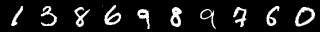

"1, 3, 8, 6, 9, 8, 9, 7, 6, 0"

In [5]:
n = size(test_images)[end]
idx = rand(1:n, 10)

hcat([test_images[:,:,i] .|> Gray for i in idx]...) |> display

join([string(model(test_images[:,:,i:i] .|> Float32 |> to_nn) |> last |> argmax |> x -> x[1]%10) for i in idx], ", ")

In [6]:
using JLD2, FileIO

path = "LeNet5-training.jld2"
acc_train, acc_test = jldopen(path, "r") do file
    acc_train = file["lenet5/training/acc_train"]
    acc_test = file["lenet5/training/acc_test"]
    (acc_train, acc_test)
end

([0.03573333333333333, 0.39823333333333333, 0.6494166666666666, 0.6821666666666667, 0.6999166666666666, 0.78565, 0.8319333333333333, 0.84885, 0.8595333333333334, 0.8668833333333333  …  0.9815, 0.9815333333333334, 0.9815833333333334, 0.98165, 0.9816833333333334, 0.9817, 0.9817333333333333, 0.9818, 0.9818333333333333, 0.9818333333333333], [0.0329, 0.398, 0.6475, 0.6864, 0.7129, 0.7992, 0.8435, 0.8598, 0.8711, 0.8751  …  0.9808, 0.9808, 0.9808, 0.9808, 0.9808, 0.9808, 0.9808, 0.9809, 0.981, 0.9811])

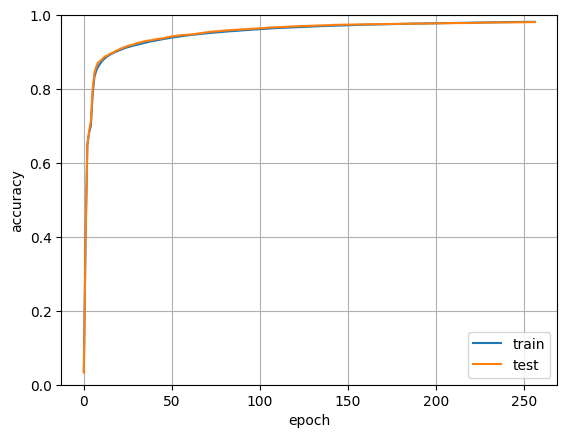

(0.0, 1.0)

In [7]:
using PyPlot

plot(acc_train, label="train")
plot(acc_test, label="test")
grid(true)
legend()
xlabel("epoch")
ylabel("accuracy")
ylim(0.0, 1.0)